# pyhf hello world

Ryan Reece <https://github.com/rreece>        
created: 2020-07-09

In [1]:
import math
import numpy as np
import pyhf

from scipy.stats import cauchy, truncexpon
import matplotlib.pyplot as plt

import hepplot as hep

In [2]:
LUMI = 1.0

## Setup the theory

In [3]:
x_min = 80.
x_max = 180.
n_xbins = 50
xlabel = '$m\ \ [\mathrm{GeV}]$'
ylabel = '$dN/dm\ /\ (2\ \mathrm{GeV})$'

In [4]:
m_Z = 91.2
gamma_Z = 2.5
func_Z = cauchy(loc=m_Z, scale=gamma_Z)
sigma_Z = 9000.

In [5]:
loc_fakes = x_min
scale_fakes = 100.
b_fakes = x_max
func_fakes = truncexpon(b_fakes, loc=loc_fakes, scale=scale_fakes)
sigma_fakes = 1000.

In [6]:
sigma_tot = sigma_Z + sigma_fakes
f_Z = sigma_Z / sigma_tot
f_fakes = sigma_fakes / sigma_tot
bkg_sigmas = [sigma_Z, sigma_fakes]

In [7]:
#signal_masses = [100., 110., 120., 130., 140., 150., 160., 170.]
signal_masses = [120., 130., 150.]
signal_widths = [ 2.*m/100. for m in signal_masses ]
signal_funcs = [ cauchy(loc=m, scale=w) for m, w in zip(signal_masses, signal_widths) ]
signal_sigmas = [ 250 - m/2 for m in signal_masses ]
signal_labels = ['$s_{100}$', '$s_{130}$', '$s_{150}$']

In [8]:
# define pdfs and normalize them over linspace x
x = np.linspace(x_min, x_max, n_xbins)
pdf_Z = func_Z.pdf(x)
pdf_fakes = func_fakes.pdf(x)
n_Z = sum(pdf_Z)
n_fakes = sum(pdf_fakes)
pdf_Z = pdf_Z / n_Z
pdf_fakes = pdf_fakes / n_fakes
pdf_tot1 = f_Z*pdf_Z + f_fakes*pdf_fakes
assert np.allclose(sum(pdf_Z), 1.0)
assert np.allclose(sum(pdf_fakes), 1.0)
assert np.allclose(sum([f_Z, f_fakes]), 1.0)
assert np.allclose(sum(pdf_tot1), 1.0)

In [9]:
f_Z

0.9

In [10]:
f_fakes

0.1

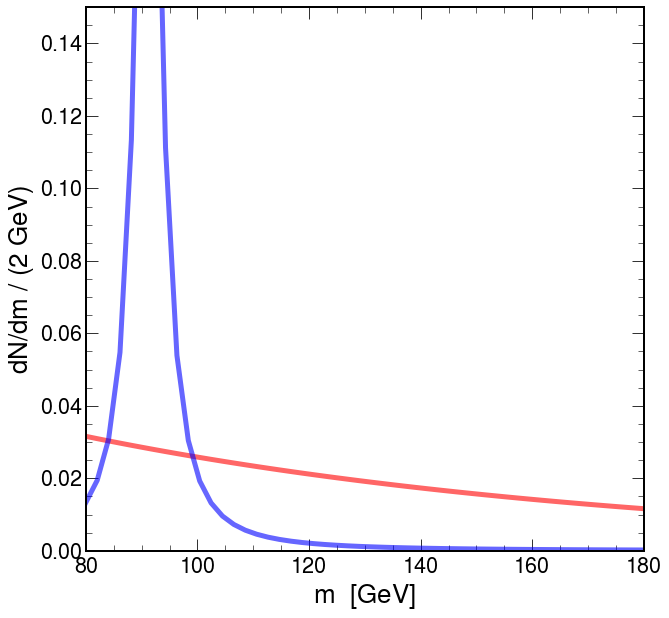

In [11]:
fig, ax = plt.subplots(1, 1)
xlims=(x_min, x_max)
ylims=(0.0, 0.15)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.plot(x, pdf_fakes, 'r-', lw=5, alpha=0.6, label='fakes')
ax.plot(x, pdf_Z, 'b-', lw=5, alpha=0.6, label='Z')

In [12]:
# make DataGenerator with mixture of pdfs
bkg_funcs = [func_Z, func_fakes]
bkg_mixtures = [f_Z, f_fakes]
bkg_gen = hep.data.DataGenerator(funcs=bkg_funcs, mixtures=bkg_mixtures)
bkg_pdf = bkg_gen.get_pdf(x)
assert np.allclose(bkg_pdf, pdf_tot1)

In [13]:
sig_gens = [ hep.data.DataGenerator(funcs=[_func], mixtures=[1.0]) for _func in signal_funcs ]

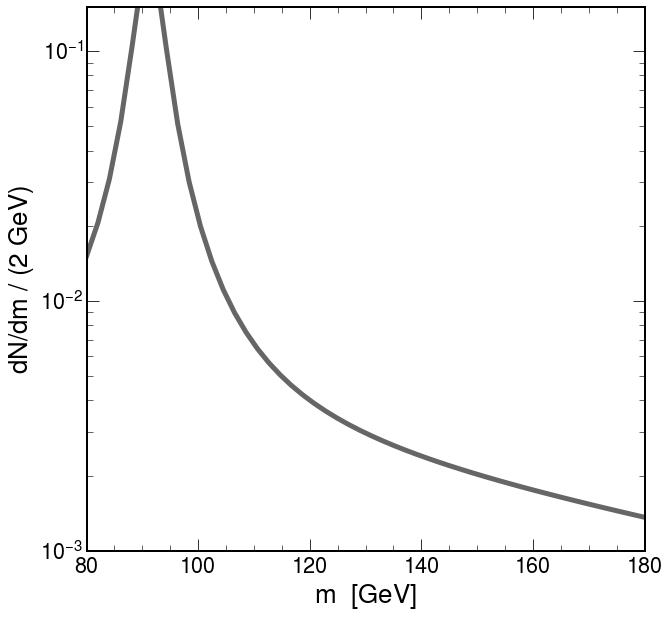

In [14]:
fig, ax = plt.subplots(1, 1)
xlims=(x_min, x_max)
#ylims=(0.0, 0.15)
ylims=(1e-3, 0.15) # logy
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_yscale('log')
ax.plot(x, bkg_pdf, 'k-', lw=5, alpha=0.6, label='pdf')

## Monte Carlo for the model

In [15]:
a_test = bkg_gen.generate(10000, i=1)
y_test = np.histogram(a_test, bins=n_xbins, range=(x_min, x_max))

In [16]:
y_test

(array([212, 203, 157, 174, 182, 178, 189, 165, 173, 157, 165, 163, 145,
        172, 153, 149, 128, 114, 156, 139, 112, 139, 140, 137, 117, 136,
        114, 117, 120, 124, 107,  85,  98, 110, 104, 107,  97,  98,  82,
         95,  89, 116,  72,  95,  83,  75,  78,  84,  76,  77]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.,
        102., 104., 106., 108., 110., 112., 114., 116., 118., 120., 122.,
        124., 126., 128., 130., 132., 134., 136., 138., 140., 142., 144.,
        146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180.]))

In [17]:
bins = list(y_test[1])

In [18]:
n_bkgs = bkg_gen.get_n()
assert len(bkg_sigmas) == n_bkgs
n_mcs = [int(1e4), int(1e4)]
bkg_hists = [ np.histogram(bkg_gen.generate(n_mcs[_i], i=_i), bins=n_xbins, range=(x_min, x_max))[0] for _i in range(n_bkgs)]
bkg_scales = [ bkg_sigmas[_i]*LUMI/n_mcs[_i] for _i in range(n_bkgs) ]
bkg_hists = [ list(bkg_hists[_i] * bkg_scales[_i]) for _i in range(n_bkgs) ]


In [19]:
bins = [ float(_b) for _b in y_test[1] ]
y = bkg_hists
xlabel = '$m$  [GeV]'
ylabel = 'Events / (2 GeV)'
labels = ['Z','Fakes']
ytotal  = [sum(_y) for _y in zip(*y)]

## gaussian errors
yerr    = [
    math.sqrt(_y) for _y in ytotal
]

In [20]:
n_signals = [50]*len(signal_masses) # TODO: use signal_sigmas
signal_grid = dict()
for _m, _sg, _n in zip(signal_masses, sig_gens, n_signals):
    _x = _sg.generate(_n)
    signal_grid[(_m,)] = list(np.histogram(_x, bins=n_xbins, range=(x_min, x_max))[0])

In [21]:
signals = list(signal_grid.values())
signal_points = list(signal_grid.keys())

In [22]:
n_data = 10000
data = list(np.histogram(bkg_gen.generate(n_data), bins=n_xbins, range=(x_min, x_max))[0])
data_label='Data'

## Histograms

(<Figure size 720x720 with 2 Axes>,
 [<AxesSubplot:ylabel='Events / (2 GeV)'>, <AxesSubplot:xlabel='$m$  [GeV]'>])

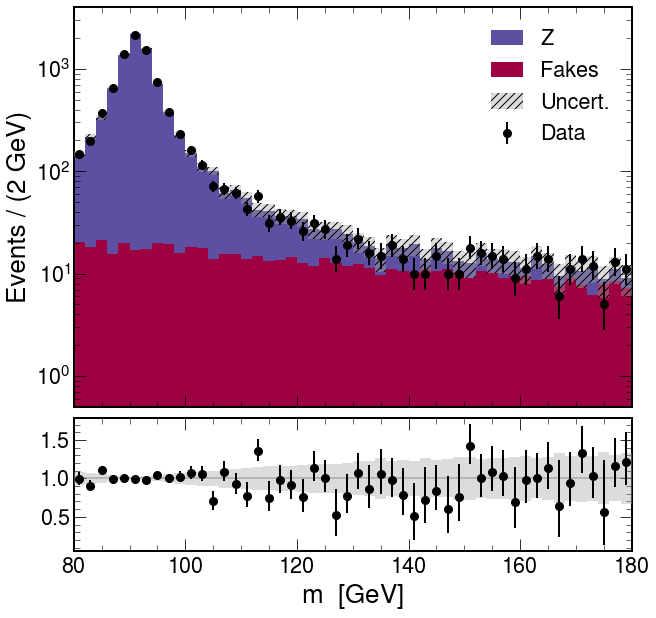

In [23]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data,
                data_label=data_label,
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(x_min, x_max),
                ylim=(0.5, 4000.0),
                yscale='log',
                ratio=True)

(<Figure size 720x720 with 2 Axes>,
 [<AxesSubplot:ylabel='Events / (2 GeV)'>, <AxesSubplot:xlabel='$m$  [GeV]'>])

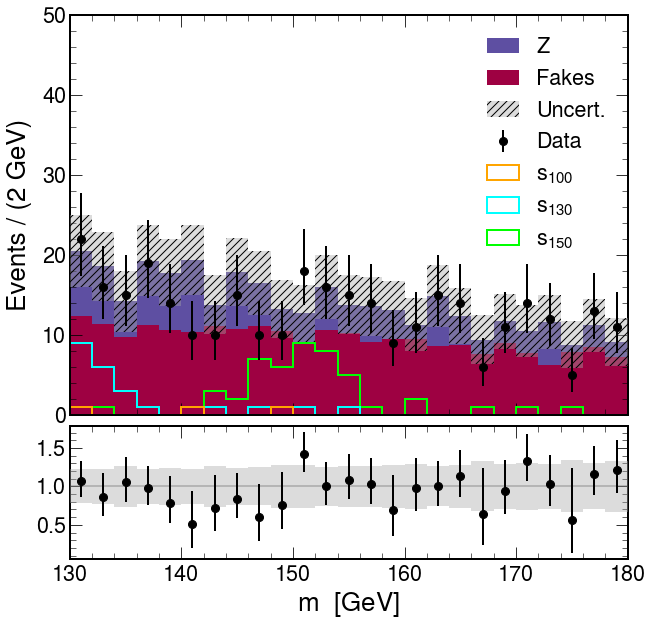

In [24]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data,
                data_label=data_label,
                signals=signals,
                signal_labels=signal_labels,
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(130, 180),
#                xlim=(x_min, x_max),
                ylim=(0.0, 50.0),
#                ylim=(0.5, 2000.0),
#                yscale='log',
                ratio=True,
                stack_signals=False)

## Hypothesis testing with pyhf

### TODO:

-   Explain `pyhf.simplemodels.hepdata_like`
    -   Marked Poisson
    -   Cranmer, K. et al. (2012). HistFactory: A tool for creating statistical models for use with RooFit and RooStats. CERN-OPEN-2012-016. <https://cds.cern.ch/record/1456844>

## Basic hypothesis test at mu=1.0

In [25]:
list_of_results = list()
for i_signal, signal in enumerate(signals):
    print('Testing signal %i' % (i_signal+1))
    model = hep.stats.make_model(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    CLs_obs, CLs_exp_band = hep.stats.hypo_test(model=model, data=data, mu=1.0)
    results = dict()
    results['model'] = model
    results['CLs_obs'] = CLs_obs
    results['CLs_exp_band'] = CLs_exp_band
    list_of_results.append(results)
    print('Expected CLs -2 sigma: %.5f' % (CLs_exp_band[0]))
    print('Expected CLs -1 sigma: %.5f' % (CLs_exp_band[1]))
    print('Expected CLs         : %.5f' % (CLs_exp_band[2]))
    print('Expected CLs +1 sigma: %.5f' % (CLs_exp_band[3]))
    print('Expected CLs +2 sigma: %.5f' % (CLs_exp_band[4]))
    print('Observed CLs         : %.5f' % (CLs_obs))
    print('')

Testing signal 1
Expected CLs -2 sigma: 0.00080
Expected CLs -1 sigma: 0.00553
Expected CLs         : 0.03326
Expected CLs +1 sigma: 0.15389
Expected CLs +2 sigma: 0.45917
Observed CLs         : 0.00673

Testing signal 2
Expected CLs -2 sigma: 0.00019
Expected CLs -1 sigma: 0.00177
Expected CLs         : 0.01430
Expected CLs +1 sigma: 0.08746
Expected CLs +2 sigma: 0.33409
Observed CLs         : 0.00070

Testing signal 3
Expected CLs -2 sigma: 0.00001
Expected CLs -1 sigma: 0.00014
Expected CLs         : 0.00200
Expected CLs +1 sigma: 0.02178
Expected CLs +2 sigma: 0.14113
Observed CLs         : 0.00045



## Hypothesis test scan for a single signal

In [26]:
model = hep.stats.make_model(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signals[0])
mu_bounds = (0, 5)
mu_step = 0.1
test_size = 0.05
hypo_tests, test_mus = hep.stats.hypo_test_scan(model, 
                                                data, 
                                                mu_bounds=mu_bounds,
                                                mu_step=mu_step)

/home/ryan/at-github/statistics-notebooks/env1/lib/python3.8/site-packages/pyhf/infer/calculators.py:357: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


In [27]:
help(model)

Help on Model in module pyhf.pdf object:

class Model(builtins.object)
 |  Model(spec, batch_size=None, **config_kwargs)
 |  
 |  The main pyhf model class.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, spec, batch_size=None, **config_kwargs)
 |      Construct a HistFactory Model.
 |      
 |      Args:
 |          spec (:obj:`jsonable`): The HistFactory JSON specification
 |          batch_size (:obj:`None` or :obj:`int`): Number of simultaneous (batched) Models to compute.
 |          config_kwargs: Possible keyword arguments for the model configuration
 |      
 |      Returns:
 |          model (:class:`~pyhf.pdf.Model`): The Model instance.
 |  
 |  constraint_logpdf(self, auxdata, pars)
 |      Compute the log value of the constraint pdf.
 |      
 |      Args:
 |          auxdata (:obj:`tensor`): The auxiliary measurement data
 |          pars (:obj:`tensor`): The parameter values
 |      
 |      Returns:
 |          Tensor: The log density value
 |  
 |  expected_actu

In [28]:
hypo_tests

[(array(nan), [array(1.), array(1.), array(1.), array(1.), array(1.)]),
 (array(0.7212939),
  [array(0.59017311),
   array(0.70871379),
   array(0.8308219),
   array(0.932043),
   array(0.9853968)]),
 (array(0.50145218),
  [array(0.33436796),
   array(0.48377936),
   array(0.66919833),
   array(0.851724),
   array(0.96404394)]),
 (array(0.33571016),
  [array(0.18180427),
   array(0.31782182),
   array(0.52168163),
   array(0.76103637),
   array(0.93421906)]),
 (array(0.21627253),
  [array(0.0948476),
   array(0.20081799),
   array(0.39303721),
   array(0.66321329),
   array(0.89442541)]),
 (array(0.13399407),
  [array(0.04747106),
   array(0.12197809),
   array(0.28583177),
   array(0.56239415),
   array(0.8437043)]),
 (array(0.079805),
  [array(0.02279404),
   array(0.07120029),
   array(0.20045565),
   array(0.4631171),
   array(0.78194859)]),
 (array(0.04567568),
  [array(0.01049994),
   array(0.0399273),
   array(0.13545528),
   array(0.36968284),
   array(0.71010175)]),
 (array(0.

In [29]:
cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$\\mu$', ylabel='CLs'>)

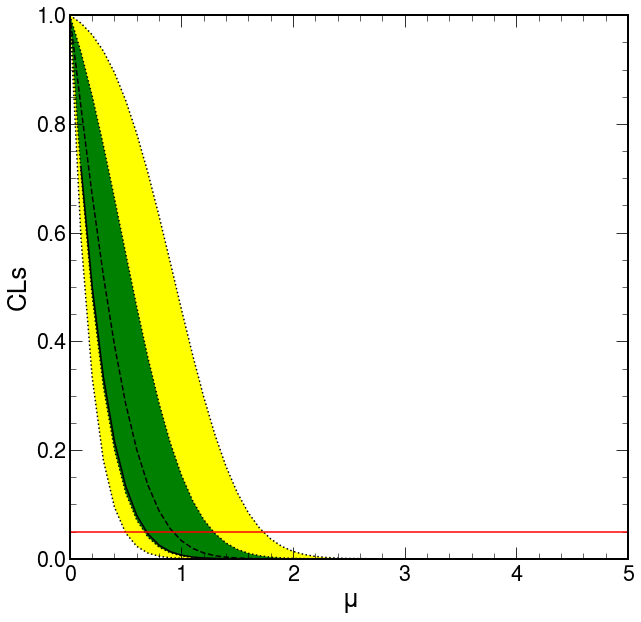

In [30]:
hep.plot.brazil(x=test_mus, exp=cls_exp, obs=cls_obs,
                xlabel=r'$\mu$',
                ylabel=r'CLs',
                xlim=mu_bounds,
                ylim=(0.0, 1.0),
                yline=test_size,
                )

In [31]:
hep.stats.invert_interval(hypo_tests, test_mus, test_size=test_size)

{'exp': [0.4946620347320253,
  0.6677910464894743,
  0.9237077116947376,
  1.2862209855853677,
  1.7326428016593844],
 'obs': 0.6873296049069797}

## Hypothesis test scan across signals

In [32]:
exclusions = list()
signal_ms = list()
for signal_point, signal in signal_grid.items():
    assert len(signal_point) == 1
    signal_ms.append(signal_point[0])
    model = hep.stats.make_model(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    hypo_tests, test_mus = hep.stats.hypo_test_scan(model, 
                                                    data, 
                                                    mu_bounds=mu_bounds)
    exclusion = hep.stats.invert_interval(hypo_tests, test_mus)
    exclusions.append(exclusion)

/home/ryan/at-github/statistics-notebooks/env1/lib/python3.8/site-packages/pyhf/infer/calculators.py:357: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


In [33]:
exclusions

[{'exp': [0.4946620347320253,
   0.6677910464894743,
   0.9237077116947376,
   1.2862209855853677,
   1.7326428016593844],
  'obs': 0.6873296049069797},
 {'exp': [0.43428839274405373,
   0.5787210348723355,
   0.7982547279726145,
   1.1183794713230537,
   1.508127943521084],
  'obs': 0.501816680605246},
 {'exp': [0.3474244167976123,
   0.4609999134922548,
   0.6355271060165444,
   0.8837890763825468,
   1.1918660706644295],
  'obs': 0.5227393454577256}]

In [34]:
cls_exp = [np.array([exc['exp'][i] for exc in exclusions]).flatten() for i in range(5)]
cls_obs = np.array([exc['obs'] for exc in exclusions]).flatten()

In [35]:
cls_obs

array([0.6873296 , 0.50181668, 0.52273935])

In [36]:
cls_exp

[array([0.49466203, 0.43428839, 0.34742442]),
 array([0.66779105, 0.57872103, 0.46099991]),
 array([0.92370771, 0.79825473, 0.63552711]),
 array([1.28622099, 1.11837947, 0.88378908]),
 array([1.7326428 , 1.50812794, 1.19186607])]

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$m$  [GeV]', ylabel='$\\mu\\ \\mathrm{excluded\\ at\\ 95\\%\\ CL}$'>)

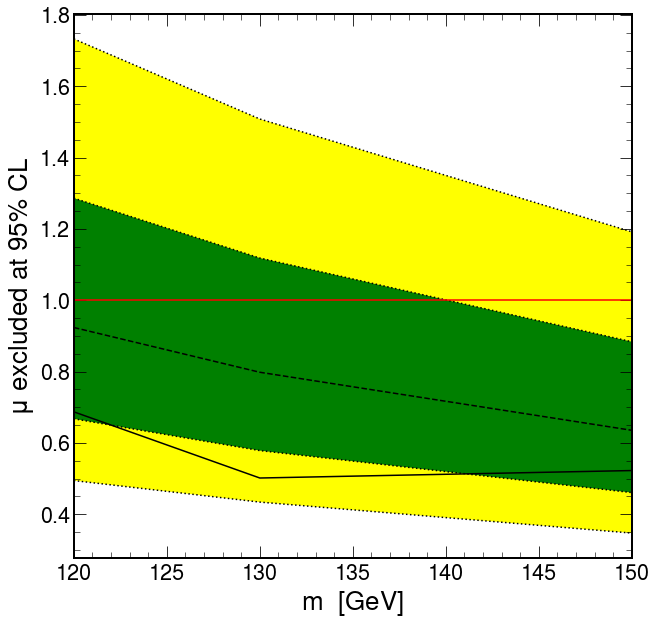

In [37]:
hep.plot.brazil(x=signal_ms, exp=cls_exp, obs=cls_obs,
                xlabel=xlabel,
                ylabel=r'$\mu\ \mathrm{excluded\ at\ 95\%\ CL}$',
                xlim=(signal_masses[0], signal_masses[-1]),
                yline=1.0)

## TODO:

-   Revist conventions for storing results of hypo tests: `CLs_obs, CLs_exp_band`
-   Clean up function above for plotting mu excluded vs one theoretical param.
-   Write a function for plotting an exclusion contour in 2-D theoretical paramter space.
-   Write functions for showing hists pre and post fit.
-   Understand where all the implicit fitting and computation is and document it. Time the execution of parts.
-   Remind myself and understand the interpolations used.
-   How to add systematics in pyhf?

## TODO: Learn about these

In [38]:
model = hep.stats.make_model(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signals[0])

In [39]:
best_fit = pyhf.infer.mle.fit(data + model.config.auxdata, model)

In [40]:
best_fit

array([2.76026529e-15, 9.99323371e-01, 9.52864115e-01, 1.05638749e+00,
       9.97986401e-01, 1.00570210e+00, 9.97557766e-01, 9.91021917e-01,
       1.02259793e+00, 1.00451404e+00, 1.01034016e+00, 1.03846318e+00,
       1.02967994e+00, 8.50784003e-01, 1.04383329e+00, 9.62124983e-01,
       8.88084293e-01, 1.17857520e+00, 8.75289126e-01, 9.87808419e-01,
       9.54536446e-01, 8.80113677e-01, 1.06985673e+00, 1.00561202e+00,
       7.59252465e-01, 8.86174872e-01, 1.03656977e+00, 9.30106859e-01,
       1.02816922e+00, 9.92206352e-01, 8.93273107e-01, 7.57714795e-01,
       8.62322611e-01, 9.18969335e-01, 8.03024291e-01, 8.78820288e-01,
       1.20866937e+00, 1.00000000e+00, 1.04346909e+00, 1.01468434e+00,
       8.43482636e-01, 9.86713333e-01, 1.00339081e+00, 1.06452396e+00,
       8.19156832e-01, 9.70092618e-01, 1.16669262e+00, 1.01725725e+00,
       7.84066884e-01, 1.08036415e+00, 1.10440176e+00])

In [41]:
nominal = model.config.suggested_init()
background_only = model.config.suggested_init()
background_only[model.config.poi_index] = 0.0
best_fit = pyhf.infer.mle.fit(data + model.config.auxdata, model)

In [42]:
nominal

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [43]:
background_only

[0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [44]:
par_bounds = model.config.suggested_bounds()

In [45]:
par_bounds

[(0, 10),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0)]

In [46]:
unconpars = pyhf.infer.mle.fit(data + model.config.auxdata, model, nominal, par_bounds)
print("parameters post unconstrained fit: {}".format(unconpars))

parameters post unconstrained fit: [2.76026529e-15 9.99323371e-01 9.52864115e-01 1.05638749e+00
 9.97986401e-01 1.00570210e+00 9.97557766e-01 9.91021917e-01
 1.02259793e+00 1.00451404e+00 1.01034016e+00 1.03846318e+00
 1.02967994e+00 8.50784003e-01 1.04383329e+00 9.62124983e-01
 8.88084293e-01 1.17857520e+00 8.75289126e-01 9.87808419e-01
 9.54536446e-01 8.80113677e-01 1.06985673e+00 1.00561202e+00
 7.59252465e-01 8.86174872e-01 1.03656977e+00 9.30106859e-01
 1.02816922e+00 9.92206352e-01 8.93273107e-01 7.57714795e-01
 8.62322611e-01 9.18969335e-01 8.03024291e-01 8.78820288e-01
 1.20866937e+00 1.00000000e+00 1.04346909e+00 1.01468434e+00
 8.43482636e-01 9.86713333e-01 1.00339081e+00 1.06452396e+00
 8.19156832e-01 9.70092618e-01 1.16669262e+00 1.01725725e+00
 7.84066884e-01 1.08036415e+00 1.10440176e+00]


In [47]:
conpars = pyhf.infer.mle.fixed_poi_fit(0.0, data + model.config.auxdata, model, nominal, par_bounds)
print("parameters post constrained fit: {}".format(conpars))

parameters post constrained fit: [0.         0.99933361 0.95286033 1.05638261 0.99798184 1.00569608
 0.99755739 0.99102147 1.02260162 1.00450708 1.01034605 1.03847555
 1.02969319 0.85080475 1.04382762 0.96211981 0.88810537 1.17855854
 0.87531931 0.98783351 0.95455417 0.88015894 1.06985334 1.00556638
 0.75932741 0.88616313 1.03667541 0.92991193 1.02824182 0.99248057
 0.89333298 0.75771946 0.8623662  0.91901087 0.80310024 0.87888398
 1.20866971 1.         1.04349934 1.01472041 0.84337764 0.98672078
 1.00337337 1.06450821 0.81907422 0.97000012 1.1670054  1.01724662
 0.78414294 1.08021483 1.10479168]


In [48]:
model.expected_data(conpars)

array([ 147.10190675,  206.19897474,  353.14870697,  644.29707708,
       1384.13951237, 2165.2980658 , 1539.94826125,  730.85338113,
        378.2973679 ,  229.6516567 ,  155.25209511,  112.75140442,
         86.10144101,   64.29978141,   63.49990744,   49.20103745,
         49.49945848,   36.15068746,   36.45105663,   34.6503165 ,
         30.10143582,   29.10001073,   26.84862236,   20.50184018,
         21.79961296,   21.25184593,   17.29636194,   14.60103388,
         19.15487495,   15.90132712,   14.69975753,   11.90065358,
         16.45029459,   13.25115404,   11.60126848,   15.35010536,
         16.        ,   14.40029094,   13.80019752,   11.04824706,
         11.14994485,   14.95026325,   13.19990183,    7.69929762,
         11.34900141,   12.25355667,   11.80006082,    6.90045785,
         12.09840615,   10.05360429,  147.10190675,  206.19897474,
        353.14870697,  644.29707708, 1384.13951237, 2165.2980658 ,
       1539.94826125,  730.85338113,  378.2973679 ,  229.65165

In [49]:
model.config.poi_index

0

In [50]:
type(conpars)

numpy.ndarray

In [51]:
model

In [52]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_modifications',
 'batch_size',
 'config',
 'constraint_logpdf',
 'constraint_model',
 'expected_actualdata',
 'expected_auxdata',
 'expected_data',
 'fullpdf_tv',
 'logpdf',
 'main_model',
 'mainlogpdf',
 'make_pdf',
 'nominal_rates',
 'pdf',
 'schema',
 'spec',
 'version']

In [55]:
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      2,
      1,
      2,
      4,
      7,
      9,
      5,
      9,
      5,
      1,
      1,
      1,
      0,
      0,
      0,
      0,
      1,
      0,
      0,
      0,
      1,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'background',
     'data': [147.20000000000002,
      216.4,
      334.3,
      645.6,
      1376.3,
      2170.6000000000004,
      1553.8999999999999,
      714.7,
      376.6,
      227.3,
      149.5,
      109.5,
      101.2,
      61.6,
      66.0,
      55.4,
      42.0,
      41.300000000000004,
      36.900000000000006,
      36.300000000000004,
      34.2,
      27.200

In [58]:
dir(model.config)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_and_register_paramsets',
 'auxdata',
 'auxdata_order',
 'channel_nbins',
 'channel_slices',
 'channels',
 'modifier_settings',
 'modifiers',
 'nauxdata',
 'nmaindata',
 'npars',
 'par_map',
 'par_order',
 'par_slice',
 'param_set',
 'parameters',
 'poi_index',
 'poi_name',
 'samples',
 'set_poi',
 'suggested_bounds',
 'suggested_fixed',
 'suggested_init']

In [59]:
model.config.npars

51

In [60]:
model.config.modifiers

[('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]

In [61]:
model.config.par_map

{'mu': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7f66a66e4490>},
 'uncorr_bkguncrt': {'slice': slice(1, 51, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x7f66a64d1550>}}

In [63]:
model.config.parameters

['mu', 'uncorr_bkguncrt']

In [64]:
model.config.samples

['background', 'signal']

In [65]:
model.nominal_rates

array([[[[1.4720e+02, 2.1640e+02, 3.3430e+02, 6.4560e+02, 1.3763e+03,
          2.1706e+03, 1.5539e+03, 7.1470e+02, 3.7660e+02, 2.2730e+02,
          1.4950e+02, 1.0950e+02, 1.0120e+02, 6.1600e+01, 6.6000e+01,
          5.5400e+01, 4.2000e+01, 4.1300e+01, 3.6900e+01, 3.6300e+01,
          3.4200e+01, 2.7200e+01, 2.6700e+01, 2.7000e+01, 2.4600e+01,
          2.0500e+01, 1.8600e+01, 1.4200e+01, 1.9300e+01, 1.7800e+01,
          1.9400e+01, 1.3800e+01, 1.7900e+01, 1.6500e+01, 1.3200e+01,
          1.2700e+01, 1.6000e+01, 1.3800e+01, 1.3600e+01, 1.3100e+01,
          1.1300e+01, 1.4900e+01, 1.2400e+01, 9.4000e+00, 1.1700e+01,
          1.0500e+01, 1.1600e+01, 8.8000e+00, 1.1200e+01, 9.1000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
          1.0000e+00, 2.0000e+00, 4.0000e+00, 7.0000e+00, 9.0000e+00,
          5.0000e

## See also

-   Cowan, G. et al. (2010). Asymptotic formulae for likelihood-based tests of new physics. https://arxiv.org/abs/1007.1727
-   Cranmer, K. et al. (2012). HistFactory: A tool for creating statistical models for use with RooFit and RooStats. CERN-OPEN-2012-016. <https://cds.cern.ch/record/1456844>
-   Heinrich, L., Feickert, M., & Stark, G. (2018). [pyhf](https://github.com/scikit-hep/pyhf). <https://scikit-hep.org/pyhf/>
-   Feickert, M. (2018). pyhf: a pure Python implementation of HistFactory with tensors and autograd. <https://indico.cern.ch/event/759480/>
-   <https://github.com/CoffeaTeam/coffea/blob/master/coffea/hist/plot.py>
-   <https://scikit-hep.org/pyhf/examples/notebooks/multichannel-coupled-histo.html>
-   <https://scikit-hep.org/pyhf/examples/notebooks/binderexample/StatisticalAnalysis.html>